Training Deep Neural Network is difficult and getting them to converge in a reasonable amount of time can be tricky.

Batch Normalization accelerates the convergence of deep networks. 
This made it possible for practitioners to routinely train networks with over 100 layers.

# 7.5.1. Training Deep Networks

### Practical Challenges arised when training ML and NN
1. data Preprocessing 과정에 따라 결과에 큰 차이 존재.
2. variables in intermediate layer가 큰 범주 안에 존재할 수 있음
3. 깊은 네트워크는 복잡하고 쉽게 overfitting 됨. Regularization이 더 중요해짐.

BN은 개별 layer에 적용된다. 각 training iteration에서 처음 우리는 normalization of inputs을 해주는데, 이는 mean을 빼주고, standard deviation으로 나눠주는 것.

그 다음 scale coefficient와 scale offset을 적용한다.

만약, size가 1인 minibatch로 batch normalization을 진행한다면, 아무것도 얻을 수 있는 것이 없다. 이는, mean을 빼줄 때 0이 되기 때문 (그 자신이 mean이 되니까) 따라서, 충분한 크기의 mini batch를 사용해주어야 적절하다. 

* various source로부터 생성되는 noise는 최적화를 더 '빠르고', '과잉 최적화'를 줄이게 돕는다.

어쩌면, variation이 regularization의 역할을 하는 것일수도 있음.
minibatch는 따라서 50~100정도의 size일때가 가장 batch normalization이 잘 먹히는 구간이다.

* 왜 우리는 sample들의 mean, standard deviation이 아니라, 전체의 (미니배치 기준으로의) mean과 standard deviation을 사용하는가?

Once training is complete, why would we want the same image to be classified differently, depending on the batch in which it happens to reside? During training, such exact calculation is infeasible because the intermediate variables for all data examples change every time we update our model. However, once the model is trained, we can calculate the means and variances of each layer’s variables based on the entire dataset. Indeed this is standard practice for models employing batch normalization and thus batch normalization layers function differently

* training mode *(normalizing by minibatch statistics) 

* prediction mode *(normalizing by dataset statistics)

## 7.5.2.1. Fully Connected Layers
the original paper inserts batch normalization after the affine transformation and before the nonlinear activation function (later applications may insert batch normalization right after activation functions)

output = activation_fun(batch_norm(Wx+b))

## 7.5.2.2. Convolution Layers
Conv Layer에서도 마찬가지로 BN을 nonlinear activation function 이전에 적용한다. => 각 채널별로 BN은 따로해줘야 함.

When the convolution has multiple output channels, we need to carry out batch normalization for each of the outputs of these channels, and each channel has its own scale and shift parameters, both of which are scalars. Assume that our minibatches contain  𝑚  examples and that for each channel, the output of the convolution has height  𝑝  and width  𝑞 . For convolutional layers, we carry out each batch normalization over the  𝑚⋅𝑝⋅𝑞  elements per output channel simultaneously. Thus, we collect the values over all spatial locations when computing the mean and variance and consequently apply the same mean and variance within a given channel to normalize the value at each spatial location.

## 7.5.2.3. Batch Normalization During Prediction
batch normalization은 training mode와 prediction mode에서 다르게 적용된다. 
1. noise in sample mean and sample variance arising from estimating each on minibatches는 더이상, 우리가 훈련시킨 모델에 desirable하지 않게 된다. 
2. BN을 할 수 있을 luxury of computing  없을수도 >,< -> YOLO같은..

# 7.5.3. Implementation from Scratch

In [9]:
import torch 
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # "is_grad_enabled"를 통해, 지금이 training인지, prediction 중인지 알 수 있다.
    if not torch.is_grad_enabled():
        # Prediction mode일 때,
        X_hat = (X - moving_var) / torch.sqrt(moving_var+eps)
    else:
        # Training mode일 때,
        assert len(X.shape) in (2,4)
        
        if len(X.shape) == 2: 
            # Fully-Connected layer의 경우,
            # feature dimension으로 mean과 var 계산하라.
            mean = X.mean(dim=0)
            var = ((X-mean)**2).mean(dim=0)
        else: 
            # two-dimensional Conv layer의 경우,
            # channel dimension(axis=1)으로 계산하라.
            mean = X.mean(dim=(0,2,3), keepdim=True)
            var = ((X-mean)**2).mean(dim=(0,2,3), keepdim=True)
        X_hat = (X-mean)/torch.sqrt(var+eps)
        
        moving_mean = momentum * moving_mean + (1.0-momentum)*mean
        moving_var = momentum * moving_var + (1.0-momentum)*var
        
    Y = gamma*X_hat + beta #Scale and shift
    return Y, moving_mean.data, moving_var.data

보통, mathematics를 seperate function으로 구현한 다음, integrate into custom layer 한다. 

-> 좀 더 개인적인 설정을 가능하게 하귀 위함.

In [10]:
class BatchNorm(nn.Module):
    # num_features: fully-connected layer의 output의 개수 OR Convlayer 채널 개수
    # num_dims: 2-fullyconnectlayer(2차원), 4-Convlayer(4차원)
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        
        # scale param, shift param은 각각 0,1로 지정 (initialize)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        
        # model param이 아닌 변수들도 0,1로 초기화
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self,X):
        # 그냥 device 설정
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 업데이트된 moving_mean, moving_var을 저장
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var,eps=1e-5, momentum=0.9)
        return Y

# 7.5.4. Applying BN in LeNet

In [11]:
net = nn.Sequential(nn.Conv2d(1,6,kernel_size=5),BatchNorm(6,num_dims=4),
                   nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                   nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
                   nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
                   
                   nn.Flatten(), nn.Linear(16*4*4, 120),
                   BatchNorm(120, num_dims=2),nn.Sigmoid(),
                   nn.Linear(120, 84), BatchNorm(84, num_dims=2),
                   nn.Sigmoid(), nn.Linear(84, 10))

loss 0.268, train acc 0.901, test acc 0.138
5851.7 examples/sec on cpu


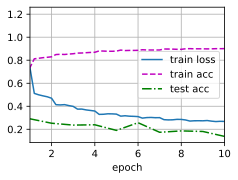

In [12]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())